In [1462]:
import pandas as pd

In [1463]:
import matplotlib.pyplot as plt

In [1464]:
import numpy as np

In [1465]:
from fastprogress import progress_bar,master_bar

In [1466]:
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
import tensorflow as tf

In [1467]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras.utils import to_categorical

In [1468]:
data=pd.read_excel("data_set.xlsx")

In [1469]:
data.shape

(72791, 8)

In [1371]:
df=data[data.ErrorCode==0].copy()

In [1372]:
df.shape

(63505, 8)

In [1373]:
df['day'] = df.DateTime.dt.day
df['month'] = df.DateTime.dt.month
df['year'] = df.DateTime.dt.year
df['hour']=df.DateTime.dt.hour
df['weekday']=df.DateTime.dt.weekday

In [1374]:
df['Company Id']=df['Company Id'].astype(str)

In [1376]:
df['Company Id'].unique()

array(['25502921', '25750275', '25921010', '25921355', '25927159'],
      dtype=object)

In [1378]:
mapper={}
for i,comp in enumerate(df['Company Id'].unique()):
    mapper[comp]=i+1
mapper
df['comp_code']=df['Company Id'].map(mapper)

In [1380]:
df.dtypes

Company Id               object
DateTime         datetime64[ns]
ON/OFF                    int64
Level of Fuel           float64
PF                      float64
KiloWatt                float64
KWH                     float64
ErrorCode                 int64
day                       int64
month                     int64
year                      int64
hour                      int64
weekday                   int64
comp_code                 int64
dtype: object

In [1381]:
df_grp=df.groupby(['Company Id','day','month','weekday'],as_index=True)

In [1382]:
df_grp['Level of Fuel'].diff()

0           NaN
1       -19.443
2        -1.942
3        -1.103
4        -1.119
          ...  
72785     0.000
72786     0.000
72788     0.000
72789     0.000
72790     0.000
Name: Level of Fuel, Length: 63505, dtype: float64

In [1383]:
df['fuel_consumption']=df_grp['Level of Fuel'].apply(lambda x :abs(x.diff().fillna(0).apply(lambda x:min(x,0)))).values

In [1384]:
df_grp.head(10)

,Company Id,DateTime,ON/OFF,Level of Fuel,PF,KiloWatt,KWH,ErrorCode,day,month,year,hour,weekday,comp_code,fuel_consumption
0,25502921,2018-08-16 10:23:36,0,175.000,0.0,0.0,0.0,0,16,8,2018,10,3,1,0.000
1,25502921,2018-08-16 10:33:55,0,155.557,0.0,0.0,0.0,0,16,8,2018,10,3,1,19.443
2,25502921,2018-08-16 10:43:55,0,153.615,0.0,0.0,0.0,0,16,8,2018,10,3,1,1.942
3,25502921,2018-08-16 10:53:55,0,152.512,0.0,0.0,0.0,0,16,8,2018,10,3,1,1.103
4,25502921,2018-08-16 11:03:55,0,151.393,0.0,0.0,0.0,0,16,8,2018,11,3,1,1.119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72475,25927159,2018-10-16 01:23:01,0,0.000,0.0,0.0,0.0,0,16,10,2018,1,1,5,0.000
72477,25927159,2018-10-16 01:43:00,0,0.000,0.0,0.0,0.0,0,16,10,2018,1,1,5,0.000
72480,25927159,2018-10-16 02:13:00,0,0.000,0.0,0.0,0.0,0,16,10,2018,2,1,5,0.000
72482,25927159,2018-10-16 02:33:00,0,0.000,0.0,0.0,0.0,0,16,10,2018,2,1,5,0.000


In [1385]:
df.columns

Index(['Company Id', 'DateTime', 'ON/OFF', 'Level of Fuel', 'PF', 'KiloWatt',
       'KWH', 'ErrorCode', 'day', 'month', 'year', 'hour', 'weekday',
       'comp_code', 'fuel_consumption'],
      dtype='object')

In [1386]:
df.shape

(63505, 15)

In [1387]:
features=['PF','KiloWatt','KWH','fuel_consumption','hour']

In [1388]:
df[features].describe()

,PF,KiloWatt,KWH,fuel_consumption,hour
count,63505.000000,63505.000000,63505.000000,63505.000000,63505.000000
mean,0.641503,38.865762,92108.462555,0.450761,11.235729
std,0.392926,33.436755,98075.748911,8.033088,7.448979
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,25686.400391,0.000000,4.000000
50%,0.839000,37.100000,36259.000000,0.000000,11.000000
75%,0.918000,65.400000,212389.906250,0.000000,18.000000
max,0.999000,162.200000,252365.500000,450.000000,23.000000


In [1389]:
np.min(df[features])

PF                  0.0
KiloWatt            0.0
KWH                 0.0
fuel_consumption    0.0
hour                0.0
dtype: float64

In [1390]:
np.max(df[features])

PF                       0.999
KiloWatt               162.200
KWH                 252365.500
fuel_consumption       450.000
hour                    23.000
dtype: float64

In [1391]:
df[features].apply(np.log).replace(-np.inf,0).values

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  2.30258509],
       [ 0.        ,  0.        ,  0.        ,  2.96748711,  2.30258509],
       [ 0.        ,  0.        ,  0.        ,  0.66371837,  2.30258509],
       ...,
       [-0.21691284,  4.38825718, 12.43861031,  0.        ,  2.77258872],
       [-0.18753498,  4.27527626, 12.43862182,  0.        ,  2.77258872],
       [-0.17078819,  4.08092154, 12.43863371,  0.        ,  2.77258872]])

In [1392]:
df_grp

In [1393]:
df_grp.apply(len)

Company Id  day  month  weekday
25502921    1    10     0           93
            2    10     1          144
            3    10     2          107
            4    10     3          144
            5    9      2           33
                                  ... 
25927159    29   8      2          394
                 9      5          332
            30   8      3          405
                 9      6          477
            31   8      4          372
Length: 185, dtype: int64

In [1394]:
(features)

['PF', 'KiloWatt', 'KWH', 'fuel_consumption', 'hour']

In [1395]:
int_features=['PF', 'ON/OFF','KiloWatt', 'KWH', 'fuel_consumption', 'day','hour', 'weekday']
int_features

['PF',
 'ON/OFF',
 'KiloWatt',
 'KWH',
 'fuel_consumption',
 'day',
 'hour',
 'weekday']

In [1396]:
df['Company Id'].nunique()

5

In [1397]:
for n,g in df_grp:
    break

In [1398]:
g.apply(lambda x:to_categorical(x['day'],num_classes=31),axis=1)

2522    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2523    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2524    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2525    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2526    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
2610    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2611    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2612    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2613    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2614    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Length: 93, dtype: object

In [1399]:
np.log([1,2,4,5])

array([0.        , 0.69314718, 1.38629436, 1.60943791])

In [1400]:
a=np.random.randint(10,size=3)
b=np.random.randint(10,size=3)
print(a.shape)
print(b.shape)

(3,)
(3,)


In [1401]:
np.concatenate([a,b])

array([5, 3, 9, 0, 4, 0])

In [1402]:
def transform(x,features):
    continuous_features=pd.Series(np.log(list(x[features]+1)))
    comp_id=pd.Series(to_categorical(x['comp_code'],num_classes=5+1))
    day=pd.Series(to_categorical(x['day'],num_classes=31+1))
    hour=pd.Series(to_categorical(x['hour'],num_classes=24+1))
    weekday=pd.Series(to_categorical(x['weekday'],num_classes=7+1))
    x=pd.concat([continuous_features,comp_id,day,hour,weekday])
    return x
def gen(df_grp):
    for n,g in df_grp:
        yield g.apply(lambda x:transform(x,features),axis=1)

In [1406]:
b=gen(df_grp)

In [1407]:
v=b.__next__()

In [1408]:
v.shape

(93, 76)

In [1409]:
df_grp.ngroups

185

In [1410]:
df_grp.ngroups

185

### model 

In [1411]:
def gen(df_grp):
    for n,g in df_grp:
        yield (np.expand_dims(g[int_features].apply(lambda x:np.log(x+1)).values,0),np.expand_dims(g[int_features].apply(lambda x:np.log(x+1)).values,0))

In [1412]:
o=gen(df_grp)

In [1414]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_grp):
        self.df_grp=df_grp
        self.gen=self.gen_code(self.df_grp)
        self.batch_size=1
    
    def transform(self,x,features):
        continuous_features=pd.Series(np.log(list(x[features]+1)))
        comp_id=pd.Series(to_categorical(x['comp_code'],num_classes=5+1))
        day=pd.Series(to_categorical(x['day'],num_classes=31+1))
        hour=pd.Series(to_categorical(x['hour'],num_classes=24+1))
        weekday=pd.Series(to_categorical(x['weekday'],num_classes=7+1))
        x=pd.concat([continuous_features,comp_id,day,hour,weekday])
        return x

    
#     def gen(df_grp):
#         for n,g in df_grp:
#             yield (np.expand_dims(g[int_features].apply(lambda x:np.log(x+1)).values,0),np.expand_dims(g[int_features].apply(lambda x:np.log(x+1)).values,0))
    def gen_code(self,df_grp):
        for n,g in df_grp:
            yield (np.expand_dims(g.apply(lambda x:self.transform(x,features),axis=1),0))

    def __getitem__(self,index):
        try:
            x=self.gen.__next__()
            y=x
            return x,y
        except StopIteration:
            self.on_epoch_end()
            x=self.gen.__next__()
            y=x
            return x,y
    def __len__(self,):
        return int(np.floor(self.df_grp.ngroups / self.batch_size))
    
    def on_epoch_end(self):
        self.gen=self.gen_code(self.df_grp)
        

In [1415]:
train_gen=DataGenerator(df_grp)

In [1416]:
ex=train_gen.__getitem__(0)
# ex[0].shape

In [1417]:
ex[0].shape

(1, 93, 76)

In [1418]:
ex[1].shape

(1, 93, 76)

In [1419]:
feature_dim=ex[1].shape[-1]
feature_dim

76

In [1457]:

inp = Input(shape=(None, feature_dim))
lstm = LSTM(64,return_sequences=True)(inp)
out=TimeDistributed(Dense(100))(lstm)
out=Dense(feature_dim)(out)

In [1458]:
model=Model(inp,out)

In [1459]:
model.compile(metrics=['accuracy'],loss=['mae'])

In [1460]:
model.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, None, 76)]        0         
_________________________________________________________________
lstm_50 (LSTM)               (None, None, 64)          36096     
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 100)         6500      
_________________________________________________________________
dense_59 (Dense)             (None, None, 10)          1010      
_________________________________________________________________
dense_60 (Dense)             (None, None, 76)          836       
Total params: 44,442
Trainable params: 44,442
Non-trainable params: 0
_________________________________________________________________


In [1461]:
model.fit_generator(train_gen,verbose=1,epochs=10,validation_steps=1)

Epoch 1/10
185/185 [==============================] - 182s 984ms/step - loss: 0.2011 - accuracy: 0.1440
Epoch 2/10
123/185 [==================>...........] - ETA: 54s - loss: 0.1297 - accuracy: 0.3145

KeyboardInterrupt: 

In [ ]:
daily_observations=[]
for index,group in progress_bar(df_grp):
    sample=(np.expand_dims(group.apply(lambda x:transform(x,features),axis=1),0))
    result=model.predict(sample)
    reconstruction_loss=[np.mean(tf.keras.losses.mean_absolute_error(sample,result))]
    daily_observations.append(list(index) + reconstruction_loss)
reconstruction_loss

In [937]:
# daily_observations=[]
# for index,group in progress_bar(df_grp):
#     sample=np.expand_dims(group[int_features].apply(lambda x:np.log(x+1)).values,0)
#     result=model.predict(sample)
#     reconstruction_loss=[np.mean(tf.keras.losses.mean_absolute_error(sample,result))]
#     daily_observations.append(list(index) + reconstruction_loss)
# reconstruction_loss

[0.09764056]

In [1426]:
reconstruction_loss

[0.09115375]

In [1427]:
data=pd.DataFrame(daily_observations)

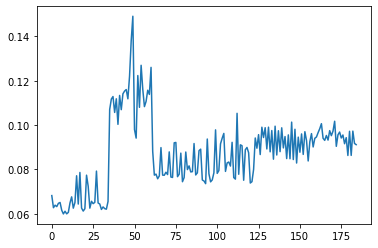

In [1428]:
data[4].plot()

In [1429]:
data[4].describe()

count    185.000000
mean       0.087340
std        0.016276
min        0.059926
25%        0.076719
50%        0.088002
75%        0.096219
max        0.149052
Name: 4, dtype: float64

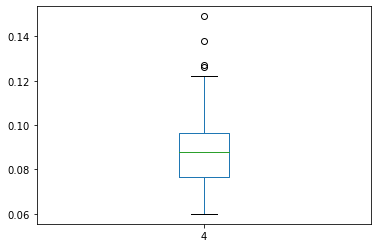

In [1430]:
data[4].plot.box()

In [1431]:
company_id=data[0].unique()
company_id

array(['25502921', '25750275', '25921010', '25921355', '25927159'],
      dtype=object)

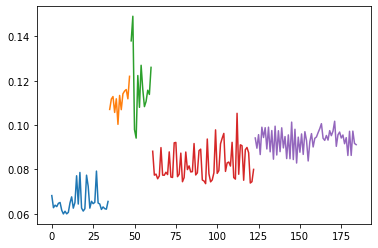

In [1432]:
for comp_id in company_id:
    data[data[0]==comp_id][4].plot()

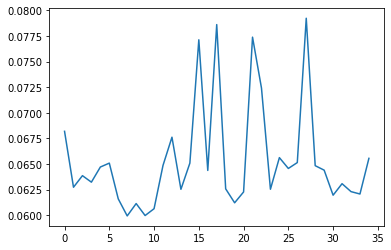

In [1433]:
data[data[0]==company_id[0]][4].plot()

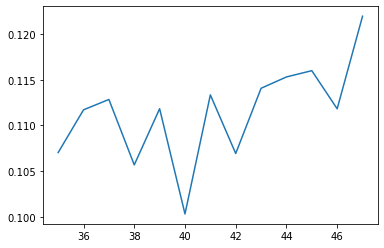

In [1434]:
data[data[0]==company_id[1]][4].plot()

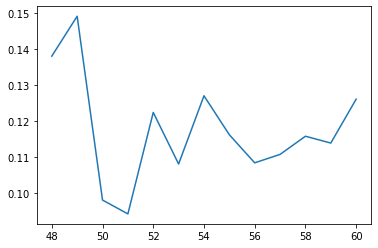

In [1435]:
data[data[0]==company_id[2]][4].plot()

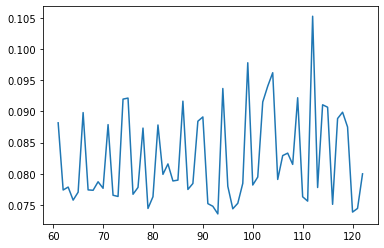

In [1436]:
data[data[0]==company_id[3]][4].plot()

In [1437]:
data[data[0]==company_id[1]][4].describe()

count    13.000000
mean      0.111452
std       0.005449
min       0.100310
25%       0.107034
50%       0.111834
75%       0.114072
max       0.121964
Name: 4, dtype: float64